# Compare geodesic vs euclidean distance embedding

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from nilearn import datasets, image, plotting
from nilearn.image import get_data
from fugw.scripts import lmds

In [24]:
n_subjects = 2

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]
n_training_contrasts = 4

brain_data = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
    get_anats=True,
)

source_imgs_paths = brain_data["cmaps"][0 : len(contrasts)]
target_imgs_paths = brain_data["cmaps"][len(contrasts) : 2 * len(contrasts)]

/opt/homebrew/lib/python3.11/site-packages/nilearn/datasets/func.py:763: UserWarning:

`legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.



In [25]:
source_im = image.load_img(source_imgs_paths)
target_im = image.load_img(target_imgs_paths)
assert source_im.shape == target_im.shape

In [26]:
source_features = np.nan_to_num(source_im.get_fdata())
target_features = np.nan_to_num(target_im.get_fdata())

#Z = 0
#plt.imshow(source_features[:,:,Z,0], cmap='gray')
#plt.show()


SCALE_FACTOR = 2


source_features = source_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
target_features = target_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
data = source_features[:,:,:,0] !=0


source_features = torch.Tensor(source_features[data].T)
target_features = torch.Tensor(target_features[data].T)

## Compute distance matrix

In [27]:
#from scipy.spatial import distance_matrix
#mat = np.array(np.nonzero(data)).T
#source_geometry = distance_matrix(mat, mat)
#target_geometry = source_geometry.copy()
#plt.imshow(source_geometry)

In [28]:
data.shape

(27, 32, 23)

In [29]:
from fugw.scripts import lmds
mat = np.array(np.nonzero(data)).T
source_embeddings = lmds.compute_lmds(torch.Tensor(mat), method="geodesic", n_landmarks=100, k=3)
target_embeddings = source_embeddings.clone()
#approx_distance = source_geometry @ source_geometry.T
#plt.imshow(approx_distance)

Output()

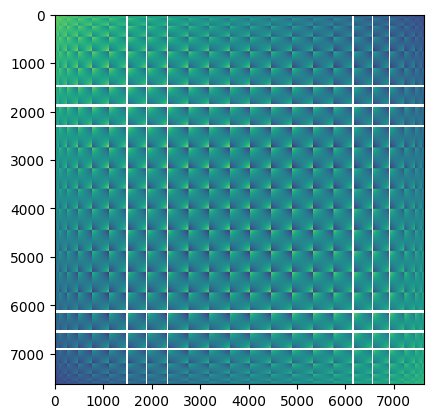

In [30]:
plt.imshow(source_embeddings @ source_embeddings.T)

In [31]:
import plotly.express as px

vertex_index = 0

fig = px.scatter_3d(x=mat[:,0], y=mat[:,1], z=mat[:,2], color=source_embeddings[:,vertex_index])
fig.update_traces(marker_size = 5)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=True )
fig.show()

In [22]:
# Normalization
source_features_normalized = source_features / torch.linalg.norm(
    source_features, dim=1
).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(
    target_features, dim=1
).reshape(-1, 1)

source_geometry_normalized = source_embeddings @ source_embeddings.T / torch.max(source_embeddings)
target_geometry_normalized = target_embeddings @ target_embeddings.T / torch.max(target_embeddings)

In [20]:
# Mapping training
from fugw.mappings import FUGW
mapping = FUGW(alpha=0.5, rho=1, eps=1e-4)
_ = mapping.fit(
    source_features_normalized[:n_training_contrasts],
    target_features_normalized[:n_training_contrasts],
    source_geometry=source_geometry_normalized,
    target_geometry=target_geometry_normalized,
    solver="sinkhorn",
    solver_params={
        "nits_bcd": 3,
    },
    verbose=True,
)

Output()

Output()

[17:41:54] BCD step 1/3    FUGW loss:      nan (base)      Validation loss:        nan (base)      nan ]8;id=213561;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=519353;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#387\387]8;;\
           (entropic)                                                                                              

           There is NaN in coupling                                                                    ]8;id=717605;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=681746;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#404\404]8;;\

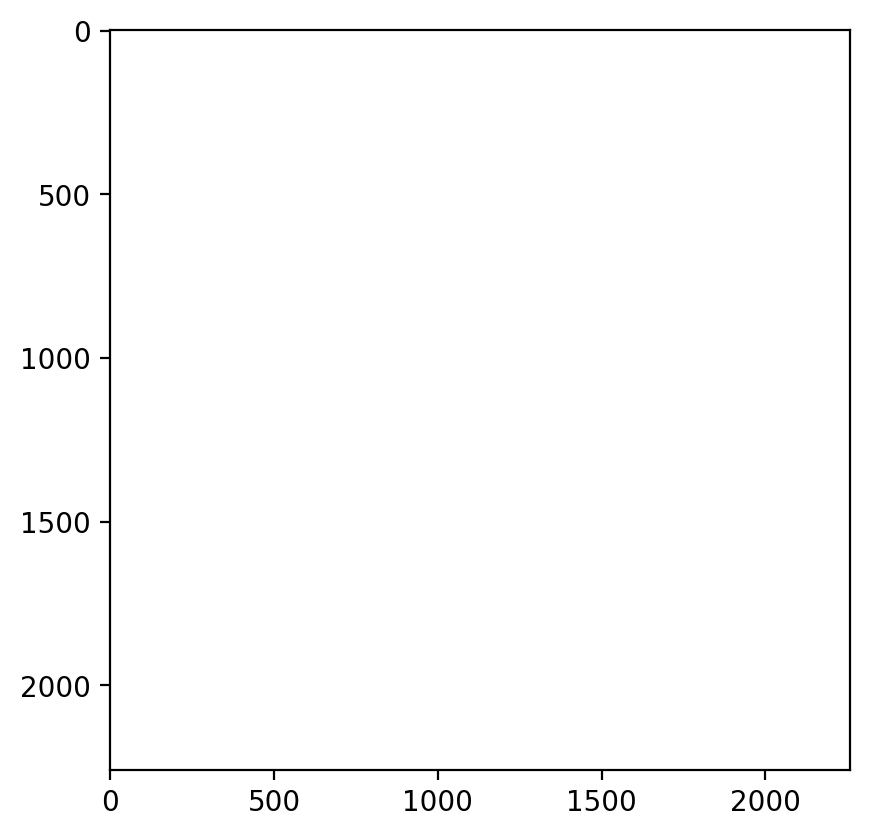

In [75]:
# Show mapping
pi = mapping.pi
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200
plt.imshow(pi, cmap='viridis')
plt.show()
plt.rcParams['figure.dpi'] = 100

In [76]:
# Reverse probability map
import plotly
vertex_index = 1700

probability_map = pi[vertex_index, :] / np.sqrt(np.linalg.norm(pi[vertex_index, :]))

fig = px.scatter_3d(x=mat[:,0], y=mat[:,1], z=mat[:,2], color=np.asarray(probability_map), 
                    color_continuous_scale=plotly.colors.sequential.Reds)
fig.update_traces(marker_size = 5)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

In [77]:
# Predict target features
contrast_index = -1
predicted_target_features = mapping.transform(
    source_features[contrast_index, :]
)
predicted_target_features.shape

torch.Size([2258])

In [78]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3,
                    specs=[[{"type": "scene"}, {"type": "scene"}, {"type": "scene"}]],
                    subplot_titles=("Source contrast", "Predicted target", "Actual target"))

fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers', 
                marker = dict(size = 4, color = np.asarray(source_features[-1,:])),
                name="Source contrast"), 
    row=1, col=1
    )
fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers',
                marker = dict(size = 5, color = np.asarray(predicted_target_features)),
                name="Predicted target"), 
    row=1, col=2
    )
fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers', 
                marker = dict(size = 5, color = np.asarray(target_features[-1,:])),
                name="Actual target"), 
    row=1, col=3
    )
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=True )
fig.show()


In [79]:
corr_pre_mapping = np.corrcoef(source_features[contrast_index, :], target_features[contrast_index, :])[0,1]
corr_post_mapping = np.corrcoef(predicted_target_features, target_features[contrast_index, :])[0,1]
print(f"Pearson Correlation pre-mapping: {corr_pre_mapping:.2f}")
print(f"Pearson Correlation post-mapping: {corr_post_mapping:.2f}")
print(f"Relative improvement: {(corr_post_mapping - corr_pre_mapping) / corr_pre_mapping *100 :.2f} %")

Pearson Correlation pre-mapping: 0.38
Pearson Correlation post-mapping: nan
Relative improvement: nan %
